In [30]:
# Core libraries
import pandas as pd
import polars as pl

# Internal data access
from op_analytics.coreutils.duckdb_inmem.client import init_client, register_parquet_relation
from op_analytics.coreutils.clickhouse.oplabs import run_query_oplabs

# configurations
import sys, os
repo_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

import config
from helper import fetch_eip1559_params
from core import compute_next_base_fee_column, validate_next_base_fee

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.style.use("seaborn-v0_8-whitegrid")  # clean background
plt.rcParams.update({
    "figure.figsize": (10, 5),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "font.family": "sans-serif",
    "font.sans-serif": ["Inter", "DejaVu Sans"],
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.alpha": 0.3,
})

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
CHAIN = config.CHAIN
BLOCK_DATE = config.BLOCK_DATE

In [3]:
eip1559_params_ouput = fetch_eip1559_params(CHAIN, BLOCK_DATE)
eip1559_params_ouput

2025-11-14 23:04:50 [debug    ] connecting to OPLABS Clickhouse client... filename=client.py lineno=56 process=73959
2025-11-14 23:04:50 [info     ] loaded vault from .env file    filename=vault.py lineno=32 process=73959
2025-11-14 23:04:50 [debug    ] loaded vault: 28 items         filename=vault.py lineno=79 process=73959
2025-11-14 23:04:51 [debug    ] initialized OPLABS Clickhouse client. filename=client.py lineno=61 process=73959
✅ Fetched EIP-1559 params for op (2025-07-16)


eip1559_elasticity,eip1559_denominator,gas_limit,latest_block_number,latest_block_timestamp,basefee_scalar,operator_fee_constant,operator_fee_scalar
u64,u64,u64,u64,u32,u64,u64,u64
2,250,40000000,22929335,1752639791,5227,0,0


In [4]:
parquet_paths = [
    f"gs://oplabs-tools-data-sink/ingestion/blocks_v1/chain={CHAIN}/dt={BLOCK_DATE}/*.parquet"
]

# Load into DuckDB
ctx = init_client()
block_view = register_parquet_relation("block_view", parquet_paths)

2025-11-14 23:04:52 [info     ] initialized duckdb at /var/folders/80/jqw6kmgj7j34j0x4mcs6hcl00000gn/T/f7wrzug3/op-analytics.duck.db filename=client.py lineno=118 process=73959
2025-11-14 23:04:52 [info     ] create duckddb gcs secret      filename=client.py lineno=66 process=73959
2025-11-14 23:05:04 [info     ] registered view: 'block_view' using 1 parquet paths filename=client.py lineno=319 process=73959


In [ ]:
# Preview data 
df_sample = ctx.client.sql(f"SELECT * FROM {block_view} LIMIT 10000").pl()

print(df_sample.head()

df_sample.schema

shape: (10_000, 24)
┌─────────┬──────────┬────────────┬───────────┬───┬─────────────┬─────────────┬───────┬────────────┐
│ network ┆ chain_id ┆ timestamp  ┆ number    ┆ … ┆ extra_data  ┆ transaction ┆ chain ┆ dt         │
│ ---     ┆ ---      ┆ ---        ┆ ---       ┆   ┆ ---         ┆ _count      ┆ ---   ┆ ---        │
│ str     ┆ i32      ┆ u32        ┆ i64       ┆   ┆ str         ┆ ---         ┆ str   ┆ date       │
│         ┆          ┆            ┆           ┆   ┆             ┆ i64         ┆       ┆            │
╞═════════╪══════════╪════════════╪═══════════╪═══╪═════════════╪═════════════╪═══════╪════════════╡
│ mainnet ┆ 10       ┆ 1752624001 ┆ 138512612 ┆ … ┆ 0x00000000f ┆ 29          ┆ op    ┆ 2025-07-16 │
│         ┆          ┆            ┆           ┆   ┆ a00000002   ┆             ┆       ┆            │
│ mainnet ┆ 10       ┆ 1752624003 ┆ 138512613 ┆ … ┆ 0x00000000f ┆ 28          ┆ op    ┆ 2025-07-16 │
│         ┆          ┆            ┆           ┆   ┆ a00000002   ┆      

Schema([('network', String),
        ('chain_id', Int32),
        ('timestamp', UInt32),
        ('number', Int64),
        ('hash', String),
        ('parent_hash', String),
        ('nonce', String),
        ('sha3_uncles', String),
        ('logs_bloom', String),
        ('transactions_root', String),
        ('state_root', String),
        ('receipts_root', String),
        ('withdrawals_root', String),
        ('miner', String),
        ('difficulty', Float64),
        ('total_difficulty', Float64),
        ('size', Int64),
        ('base_fee_per_gas', Int64),
        ('gas_used', Int64),
        ('gas_limit', Int64),
        ('extra_data', String),
        ('transaction_count', Int64),
        ('chain', String),
        ('dt', Date)])

In [25]:
# simulate the next base fee
df_simulate = compute_next_base_fee_column(df_sample, eip1559_params_ouput["eip1559_elasticity"], eip1559_params_ouput["eip1559_denominator"])

# compare the predicted next base fee with the actual next base fee
df_output, summary = validate_next_base_fee(df_simulate)

In [26]:
df_output["diff"].value_counts()

diff,count
f64,u32
-37.0,1
0.0,4496
1.0,5497
-2342.0,1
20.0,2
2325.0,1
null,1
18.0,1


In [35]:
row_max_diff = df_output.filter(pl.col("diff") == df_output["diff"].min())
row_max_diff


network,chain_id,timestamp,number,hash,parent_hash,nonce,sha3_uncles,logs_bloom,transactions_root,state_root,receipts_root,withdrawals_root,miner,difficulty,total_difficulty,size,base_fee_per_gas,gas_used,gas_limit,extra_data,transaction_count,chain,dt,target_gas,delta,predicted_next_base_fee_per_gas,actual_next_base_fee_per_gas,next_block_number,diff
str,i32,u32,i64,str,str,str,str,str,str,str,str,str,str,f64,f64,i64,i64,i64,i64,str,i64,str,date,f64,f64,f64,i64,i64,f64
"""mainnet""",10,1752640375,138520799,"""0x1a6dd708a4202f466da601f9582f…","""0x64aa1b38feda9e0d2de9de92b746…","""0x0000000000000000""","""0x1dcc4de8dec75d7aab85b567b6cc…","""0xf2b6b94894c6088744f51a8ae691…","""0xacc2ab9119ee5d44f3736446375b…","""0xbf472f6e09ba5e67ccbc6eeba31d…","""0xa211213988a71741f1b274bf364a…","""0x02c6d5b6e240ef07b979b7c7db46…","""0x4200000000000000000000000000…",0.0,0.0,45932,29967,24045205,40000000,"""0x00000000fa00000002""",41,"""op""",2025-07-16,2e7,24.0,29991.0,27649,138521042,-2342.0


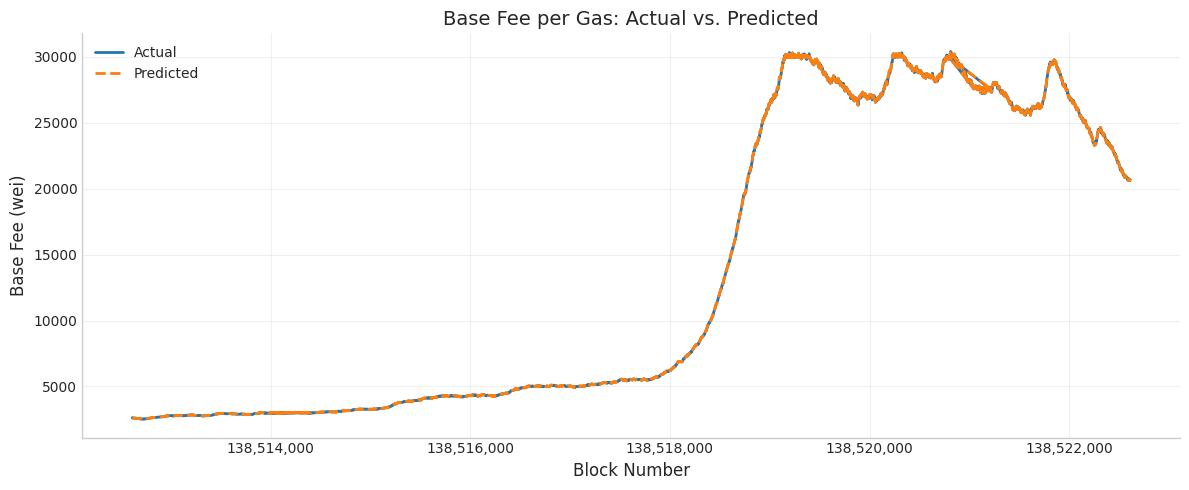

In [31]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df_output["number"], df_output["base_fee_per_gas"], label="Actual", linewidth=2)
ax.plot(df_output["number"], df_output["predicted_next_base_fee_per_gas"], label="Predicted", linestyle="--", linewidth=2)
ax.set_title("Base Fee per Gas: Actual vs. Predicted")
ax.set_xlabel("Block Number")
ax.set_ylabel("Base Fee (wei)")
ax.legend(frameon=False)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
plt.tight_layout()
plt.show()
